In [1]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta



In [2]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.209212,0.301844,0.0,0.643267,0.143476,0.0,0.262892,0.189790,0.0,0.0
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.408592,0.042243,0.0,0.765285,0.527984,0.0,0.413798,0.270021,0.0,0.0
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.514164,0.364434,0.0,0.930260,0.481733,0.0,0.273699,0.433093,0.0,0.0


In [3]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


In [4]:
patient_ids_train = np.array(x_train_scaled.index)
patient_ids_test = np.array(x_test_scaled.index)
patient_ids_train

array(['55_control', '168_CD_plain', '72_control', '120_control',
       '258_CD_plain', '254_CD_deep_ulcer', '9_CD_plain', '111_CD_plain',
       '57_CD_plain', '216_CD_deep_ulcer', '263_CD_deep_ulcer',
       '95_CD_deep_ulcer', '31_control', '172_CD_plain', '310_CD_plain',
       '68_CD_plain', '65_control', '285_CD_plain', '201_CD_plain',
       '223_CD_deep_ulcer', '320_CD_plain', '8_CD_plain',
       '99_CD_deep_ulcer', '90_control', '296_CD_deep_ulcer',
       '219_CD_deep_ulcer', '138_CD_deep_ulcer', '38_control',
       '113_CD_plain', '76_control', '146_CD_deep_ulcer',
       '147_CD_deep_ulcer', '186_CD_plain', '158_CD_plain',
       '299_CD_plain', '178_CD_plain', '189_CD_plain', '266_CD_plain',
       '231_CD_deep_ulcer', '198_CD_plain', '6_CD_deep_ulcer',
       '30_CD_plain', '265_CD_plain', '181_CD_deep_ulcer', '16_CD_plain',
       '264_CD_deep_ulcer', '209_CD_plain', '83_control', '214_CD_plain',
       '193_CD_deep_ulcer', '104_CD_plain', '66_CD_plain', '188_CD_plain

In [5]:
def classify(x):
    if "_control" in x: # control
        return 0
    elif "CD_plain" in x: # Crohn's Disease no deep ulcer
#         print(x)
        return 1
    elif "CD_deep_ulcer" in x: # Crohn's Disease deep ulcer
#         print(x)
        return 2
    else:
        return 3 # Ulcerative Collitis

vec = np.vectorize(classify)

disease_labels_train = vec(patient_ids_train)
disease_labels_test = vec(patient_ids_test)
disease_labels_train

array([0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 0, 1, 2,
       1, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 1, 0, 2, 2, 2, 0, 1, 1, 2,
       2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 1, 1, 1])

In [6]:
compound_model = keras.models.load_model('cd_clf')

In [171]:
# x_train_scaled.head(1).shape

(1, 219)

In [174]:
# compound_model.predict(x_train_scaled.head(2))

array([[0.8213127 , 0.17712823, 0.00155913],
       [0.0500554 , 0.71788126, 0.23206331]], dtype=float32)

In [7]:
compound_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 438)               96360     
                                                                 
 batch_normalization (BatchN  (None, 438)              1752      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 438)               0         
                                                                 
 dense_1 (Dense)             (None, 219)               96141     
                                                                 
 batch_normalization_1 (Batc  (None, 219)              876       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 219)               0

## SHAP evaluation

In [8]:
x_test_scaled.iloc[:2,:2]

,AADAC,APOA1
Patient_ID,,
253_CD_plain,0.869185,0.841880
105_CD_plain,0.853562,0.933532


In [9]:
import objects

In [10]:
explainer = objects.get_explainer(model=compound_model.predict, data=x_train_scaled, link="logit")

getting explainerinitialising explainer
6/6 [==============================] - 0s 2ms/step


Using 182 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Calculate SHAP values

In [11]:
# shap_values = explainer.shap_values(X=x_test_scaled)

In [12]:
# shap_values

## Save SHAP values

In [13]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [175]:


with open("shap_values_builtin_tl_219", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [15]:
shap_values = shap_values[0]

In [16]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 219)


Target Classes:
0: control
1: CD no ulcer
2: CD deep ulcer

## Patient-specific plots

In [17]:
idx = 11
patient = x_test_scaled.iloc[[idx],:]
patient

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
58_CD_plain,0.712765,0.67885,0.86582,0.855696,0.828452,0.498697,0.567772,0.352862,0.317254,0.76505,...,0.211571,0.283032,0.0,0.703328,0.556984,0.0,0.415272,0.225017,0.0,0.0


In [18]:
x_test_scaled.iloc[[0],:]

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.84188,0.930171,0.886737,0.835678,0.297964,0.668498,0.26667,0.278122,0.93352,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.34992,0.0,0.0


In [19]:
print(f'Prediction probabilities for patient: {compound_model.predict(patient)[0]}')
print("Predicted class:")

1/1 [==============================] - 0s 62ms/step
Prediction probabilities for patient: [0.05036432 0.7218582  0.22777751]
Predicted class:


#### Control

In [20]:
import shap

In [21]:

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], patient, link="logit")

####  CD no ulcer

In [22]:

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], patient, link="logit")

####  CD deep ulcer

In [23]:

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][idx,:], patient, link="logit")

In [24]:
# gene_shap.plots.bar(Explanation(x_test_scaled)[0], clustering=clustering)
idx = 11
explanation = objects.get_explanation(values=shap_values[2][idx], 
                                              base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
                                         feature_names=x_test_scaled.columns.tolist())

type(explanation)

getting explanation


_explanation.Explanation

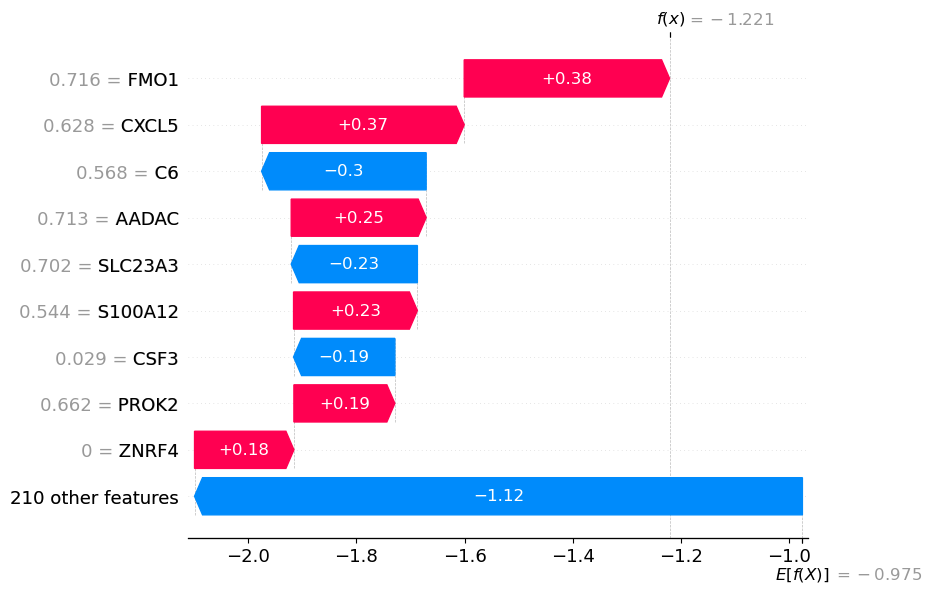

In [25]:
shap.waterfall_plot(explanation)
# shap.waterfall_plot(gene_shap.Explanation(values=shap_values[2][idx], 
#                                               base_values=explainer.expected_value[2], data=x_test_scaled.iloc[idx],  
#                                          feature_names=x_test_scaled.columns.tolist()))

#### Control

In [26]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], x_test_scaled)

####  CD no ulcer

In [27]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values[1], x_test_scaled)

####  CD deep ulcer

In [28]:
# shap.initjs()
# shap.force_plot(explainer.expected_value[2], shap_values[2], x_test_scaled)

## SHAP Summary Plots

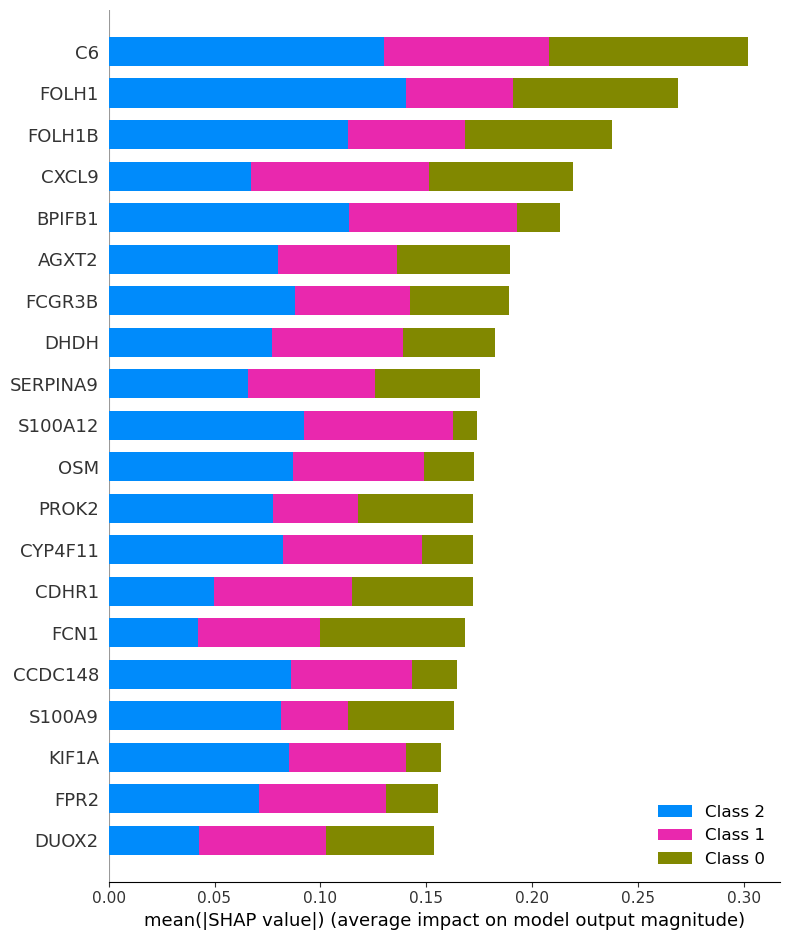

In [29]:
shap.summary_plot(shap_values, x_test_scaled)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


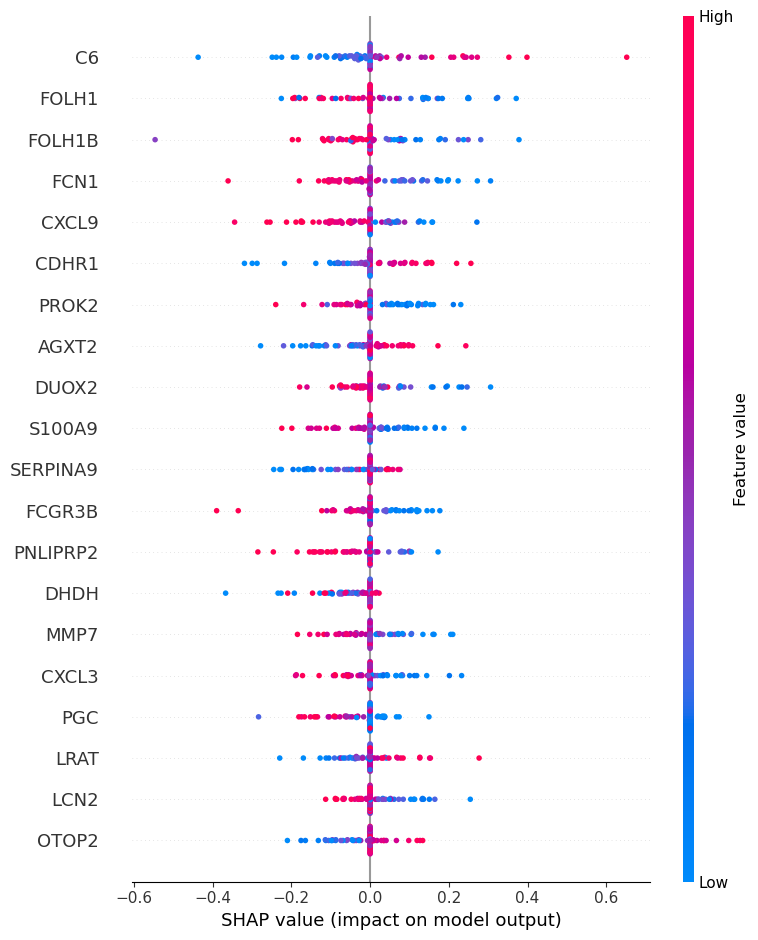

In [30]:
# control
shap.summary_plot(shap_values[0], x_test_scaled)

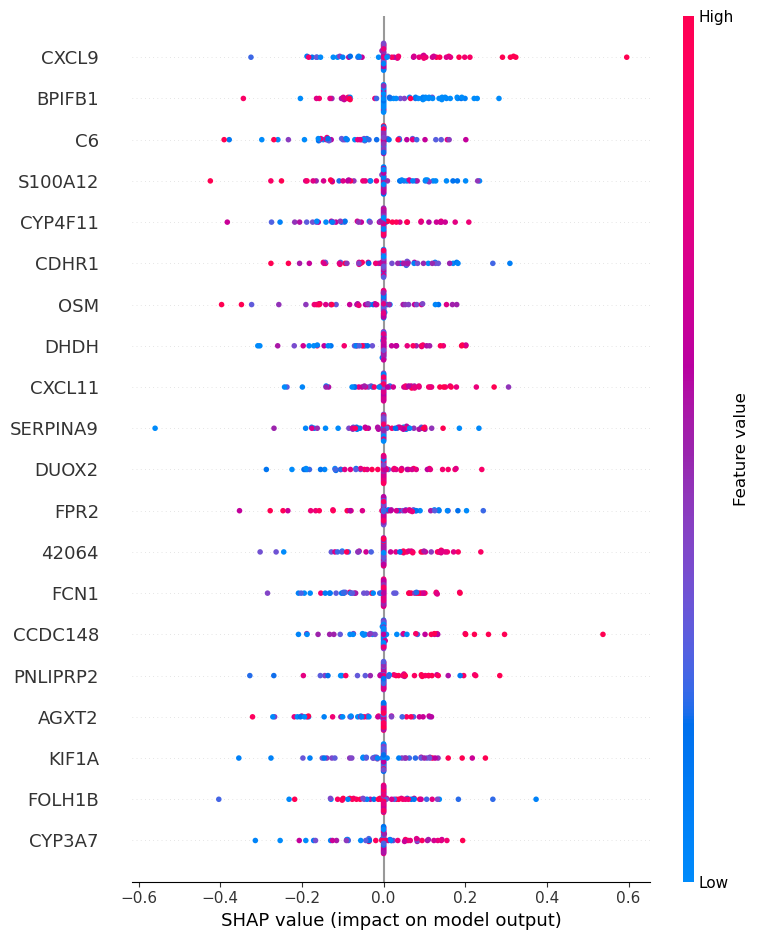

In [31]:
# CD no ulcer
shap.summary_plot(shap_values[1], x_test_scaled)

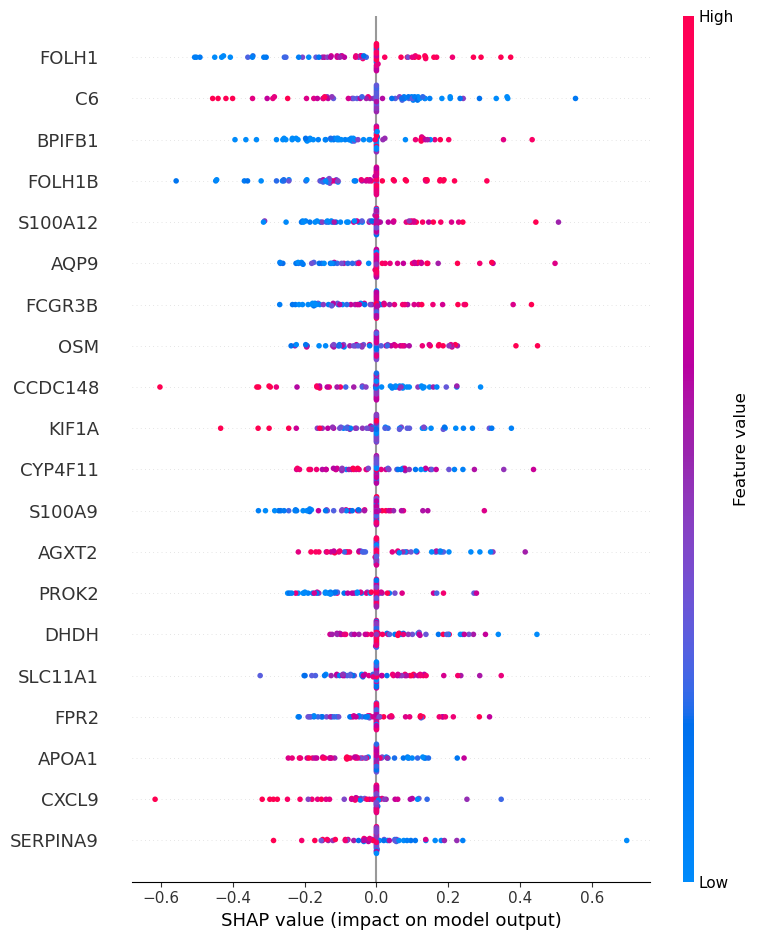

In [32]:
# CD deep ulcer
shap.summary_plot(shap_values[2], x_test_scaled)

## SHAP Dependence Plots

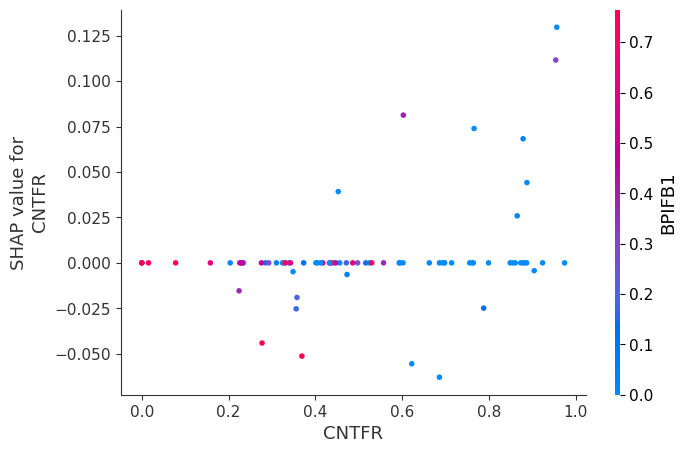

In [33]:
# control
shap.dependence_plot("CNTFR", shap_values[0], x_test_scaled)

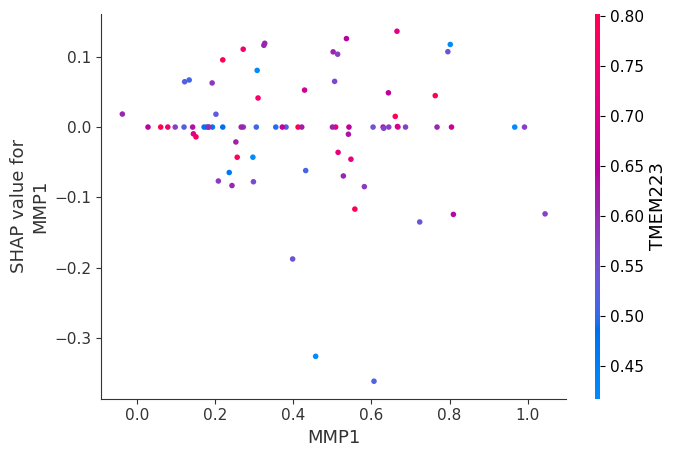

In [34]:
# CD no ulcer
shap.dependence_plot("MMP1", shap_values[1], x_test_scaled)

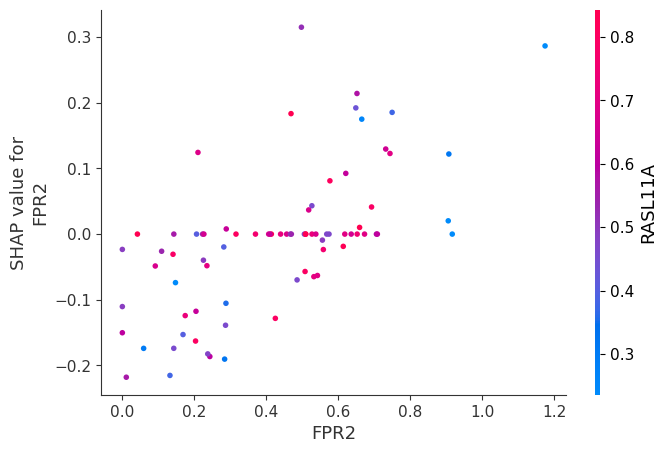

In [35]:
# CD deep ulcer
shap.dependence_plot("FPR2",shap_values[2], x_test_scaled)

## Clustering

In [36]:
disease_labels_test.shape

(78,)

In [37]:
# sys.stdout = open(1, 'w')
import sys
stdout = sys.stdout
sys.stdout = sys.__stdout__

### Current SHAP functionality

In [38]:
# clustering = objects.get_clustering(x_test_scaled, disease_labels_test)

In [39]:
# clustering

In [40]:
# clustering.shape

In [41]:
row = 70
exp = shap.Explanation(values=shap_values[2][row], base_values=explainer.expected_value[2], 
                                data=x_test_scaled.iloc[row], feature_names=x_test_scaled.columns.tolist())

# patient 8: explanations for CD deep ulcer diagnosis

In [42]:
type(exp)

shap._explanation.Explanation

In [43]:
# with open("clust", "wb") as fp:   #Pickling
#     pickle.dump(clustering, fp)

In [44]:

with open("../clust", "rb") as fp:   # Unpickling
    clustering = pickle.load(fp)

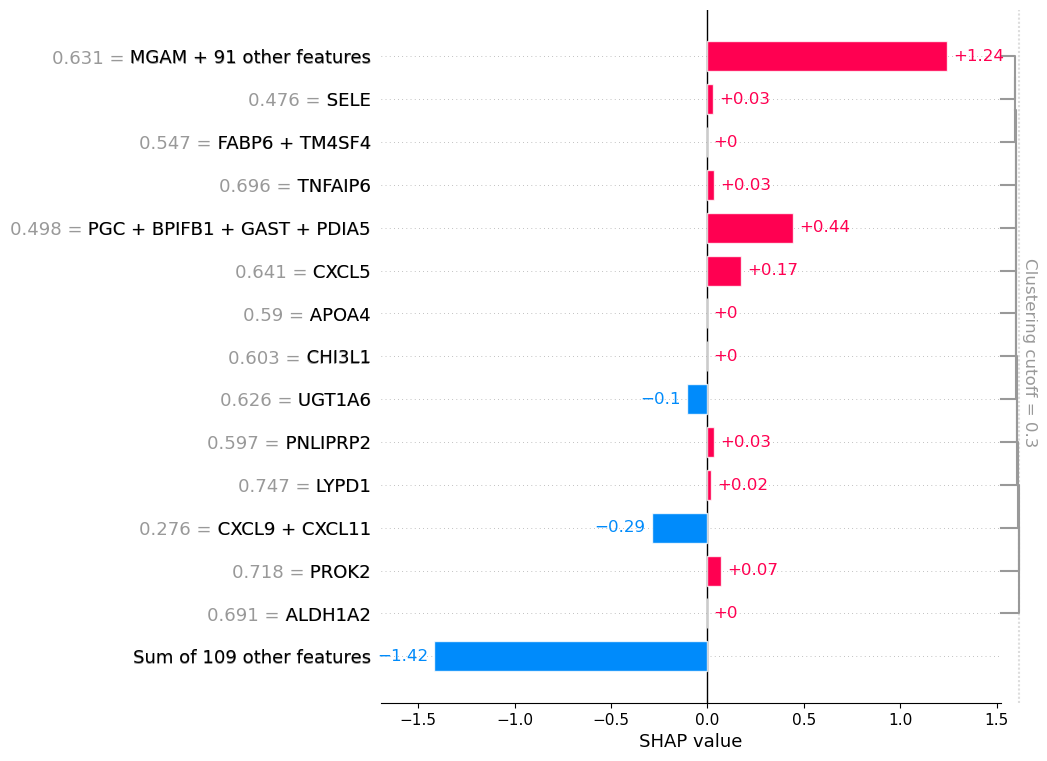

In [45]:
import shap
# shap.plots.bar(explanation, clustering=clustering)
shap.plots.bar(exp, max_display=15, clustering_cutoff=0.3,
               clustering=clustering)

## Hierarchical clustering of genes based on shap values, across all patients with given disease classification

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaders, fcluster
import seaborn as sns

In [47]:


all_gene_df = pd.DataFrame(shap_values[2], index=x_test_scaled.index, columns = x_test_scaled.columns)
df_cd_deep = all_gene_df[all_gene_df.index.str.endswith('_CD_deep_ulcer')]
df_cd_plain = all_gene_df[all_gene_df.index.str.endswith('_CD_plain')]
df_control = all_gene_df[all_gene_df.index.str.endswith('_control')]
df_cd_deep

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
62_CD_deep_ulcer,0.000000,0.000000,-0.133179,-0.088273,0.096987,0.225725,0.135073,-0.022523,0.000000,0.000000,...,0.000000,0.109125,0.0,0.000000,0.200185,0.0,0.068089,0.000000,0.0,0.000000
167_CD_deep_ulcer,0.000000,0.086586,0.000000,0.053104,-0.055615,0.000000,0.102267,0.000000,-0.033064,0.000000,...,0.000000,0.000000,0.0,0.000000,0.246101,0.0,0.000000,0.000000,0.0,0.000000
196_CD_deep_ulcer,0.064494,0.133114,-0.045823,0.000000,0.000000,0.140600,0.205572,0.182204,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-0.060370,0.000000,0.0,0.211831
23_CD_deep_ulcer,-0.045863,0.114509,0.000000,0.000000,0.000000,0.000000,0.089073,0.000000,0.000000,-0.129538,...,0.000000,0.000000,0.0,-0.037855,0.049948,0.0,0.000000,0.000000,0.0,0.000000
93_CD_deep_ulcer,0.000000,-0.044722,0.000000,0.085229,0.245953,0.113636,-0.040189,0.000000,0.000000,0.000000,...,0.120819,-0.098968,0.0,-0.019599,0.177483,0.0,-0.131126,0.000000,0.0,-0.112278
229_CD_deep_ulcer,0.003788,-0.166248,0.034763,0.234476,0.000000,0.000000,0.554286,0.000000,0.000000,0.155490,...,-0.133855,-0.109378,0.0,0.000000,-0.083117,0.0,-0.109143,-0.075203,0.0,0.000000
46_CD_deep_ulcer,-0.031186,0.000000,0.000000,0.038759,0.000000,0.024443,0.000000,0.000000,0.000000,0.000000,...,-0.119211,0.057407,0.0,0.000000,0.000000,0.0,0.000000,0.096118,0.0,0.101591
176_CD_deep_ulcer,0.000000,0.000000,0.000000,0.138268,-0.074793,0.000000,0.134853,-0.028149,0.085360,0.000000,...,-0.034142,0.000000,0.0,-0.126804,0.071264,0.0,0.000000,0.000000,0.0,0.000000
49_CD_deep_ulcer,0.000000,0.000000,-0.104665,0.261559,0.000000,-0.267402,0.000000,0.040975,-0.085660,0.000000,...,-0.078951,0.087044,0.0,0.069658,0.000000,0.0,-0.039103,-0.098694,0.0,0.000000


### Example: CD deep ulcer patients

In [95]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_deep = linkage(df_cd_deep.T, 'ward', metric='euclidean', optimal_ordering=True)

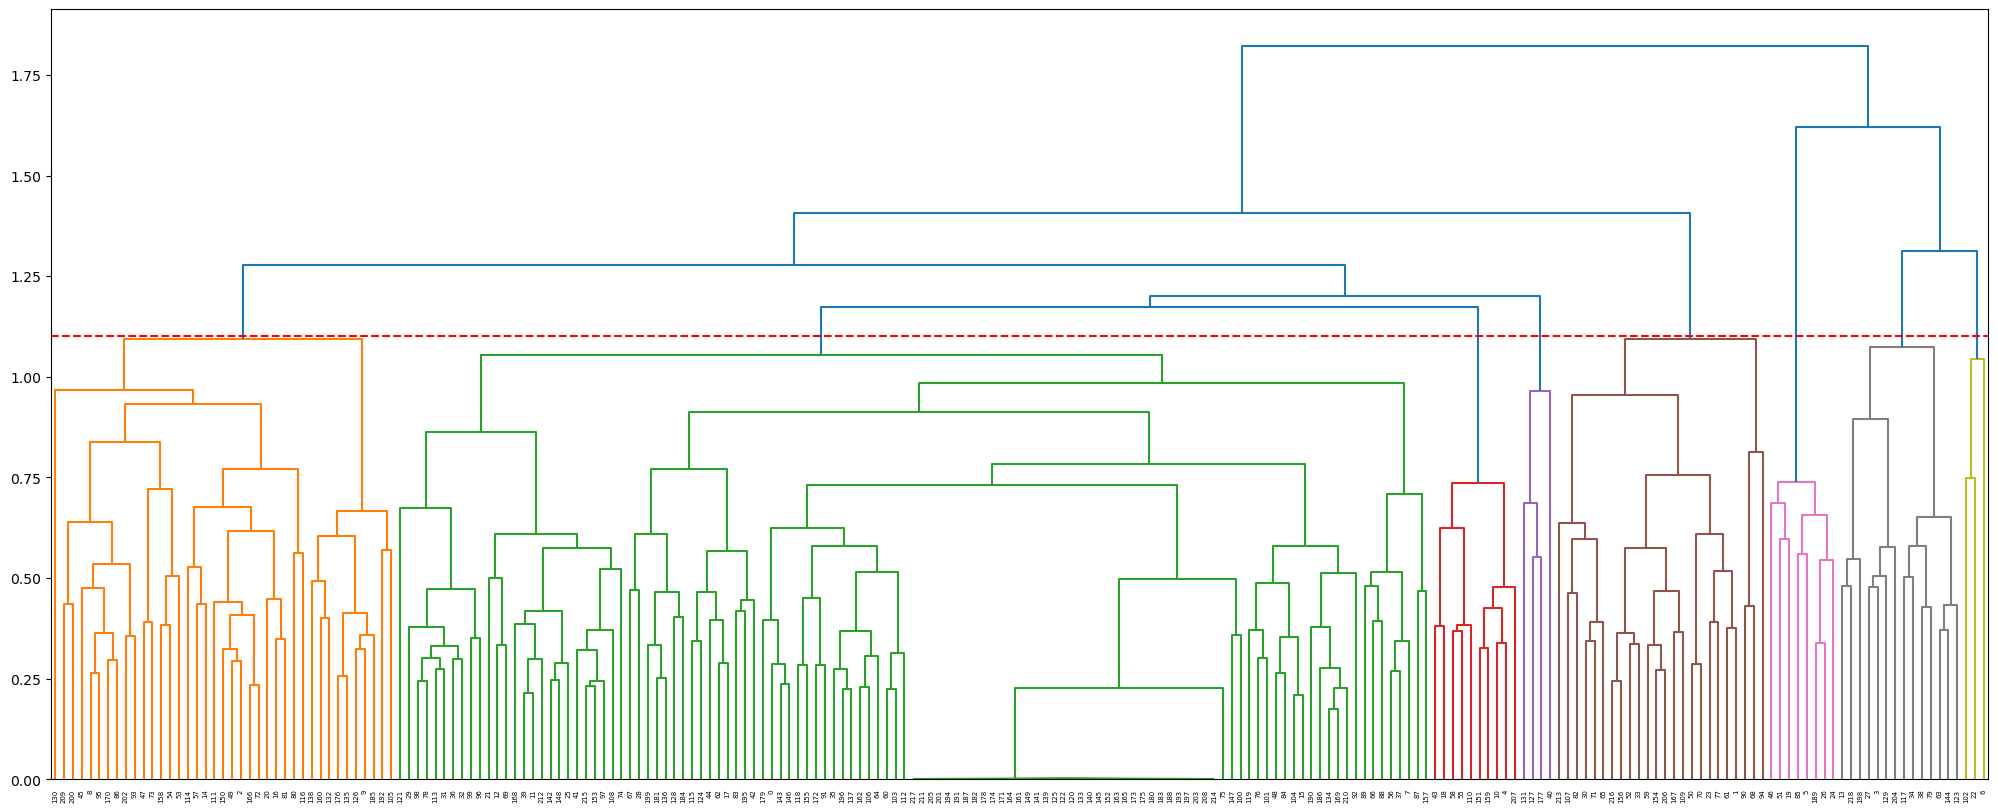

In [97]:
thresh = 1.1
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = thresh, get_leaves=True)
# dn = dendrogram(fl)
plt.axhline(y=thresh, c='r', linestyle='--')

In [98]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([130, 209, 200,  45,   8,  95, 170,  86, 202,  93,  47,  73, 158,
        54,  53, 114,  57,  14, 111, 150,  49,   2, 166,  72,  20,  16,
        81,  80, 116, 138, 160, 132, 176, 135, 126,   9, 185, 192, 105,
       121,  29,  98,  78, 113,  31,  36,  32,  99,  96,  21,  12,  69,
       168,  39,  11, 212, 142, 148,  25,  41, 215, 153,  97, 108,  74,
        67,  28, 199, 181, 136, 128, 184, 115, 124,  44,  62,  17,  83,
       195,  42, 179,   0, 143, 146, 118, 155, 172,  91,  35, 196, 137,
       162, 106,  64,  60, 103, 112, 217, 211, 205, 201, 194, 191, 187,
       182, 178, 174, 171, 164, 161, 149, 141, 139, 125, 122, 120, 133,
       140, 145, 152, 163, 165, 173, 175, 180, 183, 188, 193, 197, 203,
       208, 214,  75, 147, 100, 119,  76, 101,  48,  84, 104,  15, 190,
       186, 134, 169, 210,  92,  89,  66,  88,  56,  37,   7,  87, 157,
        43,  18,  58,  55, 110, 151, 159,  10,   4, 207, 131, 127, 177,
        40, 213, 107,  82,  30,  71,  65, 216, 156,  52,  33,  5

In [99]:
df_cd_deep.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'TAF15', 'ZFYVE20', 'LOC100420253', 'LY6G5B', 'C5orf58', 'RSL24D1P1',
       'MIEN1', 'PCBP1_AS1', 'LOC100133165', 'DNAJB8'],
      dtype='object', length=219)

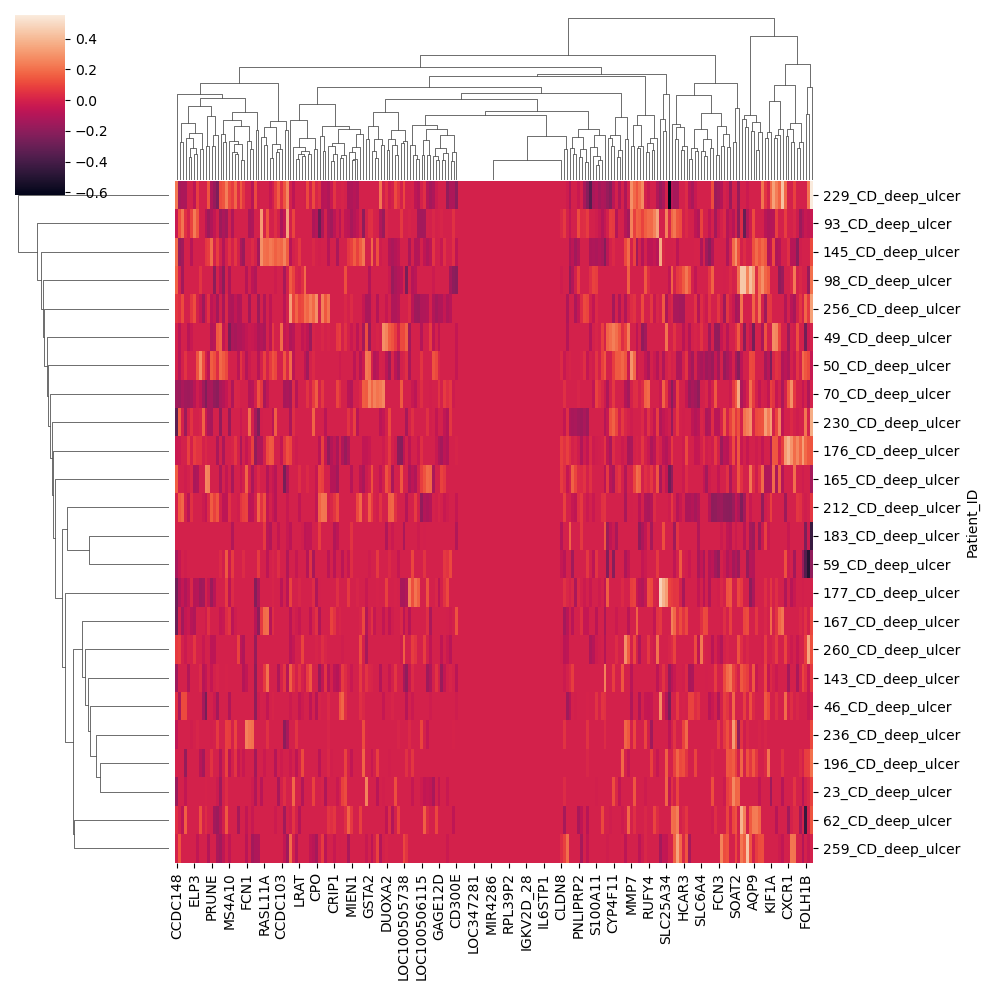

In [100]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_deep, col_linkage=gene_cluster_cd_deep)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [101]:
gene_cluster_cd_deep

array([[1.22000000e+02, 1.20000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.25000000e+02, 2.19000000e+02, 0.00000000e+00, 3.00000000e+00],
       [2.20000000e+02, 1.33000000e+02, 0.00000000e+00, 4.00000000e+00],
       [1.39000000e+02, 2.21000000e+02, 0.00000000e+00, 5.00000000e+00],
       [2.22000000e+02, 1.40000000e+02, 0.00000000e+00, 6.00000000e+00],
       [1.41000000e+02, 2.23000000e+02, 0.00000000e+00, 7.00000000e+00],
       [2.24000000e+02, 1.45000000e+02, 0.00000000e+00, 8.00000000e+00],
       [1.49000000e+02, 2.25000000e+02, 0.00000000e+00, 9.00000000e+00],
       [2.26000000e+02, 1.52000000e+02, 0.00000000e+00, 1.00000000e+01],
       [1.61000000e+02, 2.27000000e+02, 0.00000000e+00, 1.10000000e+01],
       [2.28000000e+02, 1.63000000e+02, 0.00000000e+00, 1.20000000e+01],
       [1.64000000e+02, 2.29000000e+02, 0.00000000e+00, 1.30000000e+01],
       [2.30000000e+02, 1.65000000e+02, 0.00000000e+00, 1.40000000e+01],
       [1.71000000e+02, 2.31000000e+02, 0.00000000e

In [102]:
cluster_labels = fcluster(gene_cluster_cd_deep, thresh, criterion='distance')
# label = fcluster(gene_cluster_cd_deep, 8, criterion='maxclust')
cluster_labels.shape

(219,)

In [103]:
leaders(gene_cluster_cd_deep, cluster_labels)

(array([426, 408, 422, 429, 428, 427, 425, 409], dtype=int32),
 array([2, 3, 4, 1, 5, 7, 8, 6], dtype=int32))

In [104]:
leader_ids = leaders(gene_cluster_cd_deep, cluster_labels)[1]
leader_ids

array([2, 3, 4, 1, 5, 7, 8, 6], dtype=int32)

In [105]:
cluster_labels

array([2, 5, 1, 7, 3, 6, 8, 2, 1, 1, 3, 2, 2, 7, 1, 2, 1, 2, 3, 6, 1, 2,
       8, 5, 6, 2, 6, 7, 2, 2, 5, 2, 2, 5, 7, 2, 2, 2, 7, 2, 4, 2, 2, 3,
       2, 1, 6, 1, 2, 1, 5, 6, 5, 1, 1, 3, 2, 1, 3, 5, 2, 5, 2, 7, 2, 5,
       2, 2, 5, 2, 5, 5, 1, 1, 2, 2, 2, 5, 2, 7, 1, 1, 5, 2, 2, 6, 1, 2,
       2, 2, 5, 2, 2, 1, 5, 1, 2, 2, 2, 2, 2, 2, 8, 2, 2, 1, 2, 5, 2, 5,
       3, 1, 2, 2, 1, 2, 1, 7, 2, 2, 2, 2, 2, 7, 2, 2, 1, 4, 2, 7, 1, 4,
       1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 1, 3, 2, 2,
       5, 2, 5, 2, 1, 3, 1, 2, 2, 2, 2, 2, 1, 5, 2, 2, 1, 2, 2, 2, 2, 2,
       1, 4, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 6, 2, 2, 1, 2, 2, 2, 2, 2,
       7, 2, 1, 2, 1, 2, 7, 2, 5, 3, 2, 1, 2, 2, 2, 5, 2, 2, 5, 2, 7],
      dtype=int32)

In [106]:
df_cd_deep.columns.get_loc("OSM")

46

In [107]:
np.where(cluster_labels == 2) #osm

(array([  0,   7,  11,  12,  15,  17,  21,  25,  28,  29,  31,  32,  35,
         36,  37,  39,  41,  42,  44,  48,  56,  60,  62,  64,  66,  67,
         69,  74,  75,  76,  78,  83,  84,  87,  88,  89,  91,  92,  96,
         97,  98,  99, 100, 101, 103, 104, 106, 108, 112, 113, 115, 118,
        119, 120, 121, 122, 124, 125, 128, 133, 134, 136, 137, 139, 140,
        141, 142, 143, 145, 146, 147, 148, 149, 152, 153, 155, 157, 161,
        162, 163, 164, 165, 168, 169, 171, 172, 173, 174, 175, 178, 179,
        180, 181, 182, 183, 184, 186, 187, 188, 190, 191, 193, 194, 195,
        196, 197, 199, 201, 203, 205, 208, 210, 211, 212, 214, 215, 217],
       dtype=int64),)

In [108]:
gene_df = df_cd_deep.describe().T
gene_df['gene_symbol']  = df_cd_deep.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,24.0,0.003494,0.052894,-0.096053,-0.007796,0.0,0.010791,0.123267,AADAC,2
APOA1,24.0,0.003924,0.098683,-0.211539,-0.047445,0.0,0.059390,0.224961,APOA1,5
APOA4,24.0,-0.014513,0.048960,-0.133179,-0.004154,0.0,0.000000,0.095361,APOA4,1
APOB,24.0,0.028251,0.091626,-0.120619,0.000000,0.0,0.060675,0.261559,APOB,7
APOC3,24.0,0.002064,0.061809,-0.074793,-0.024096,0.0,0.000000,0.245953,APOC3,3
...,...,...,...,...,...,...,...,...,...,...
RSL24D1P1,24.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,RSL24D1P1,2
MIEN1,24.0,-0.012032,0.054132,-0.131126,-0.038085,0.0,0.000000,0.087731,MIEN1,2
PCBP1_AS1,24.0,-0.025333,0.069765,-0.159754,-0.078898,0.0,0.000000,0.138954,PCBP1_AS1,5
LOC100133165,24.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,LOC100133165,2


In [109]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.003494,2,AADAC
APOA1,0.003924,5,APOA1
APOA4,-0.014513,1,APOA4
APOB,0.028251,7,APOB
APOC3,0.002064,3,APOC3
...,...,...,...
RSL24D1P1,0.000000,2,RSL24D1P1
MIEN1,-0.012032,2,MIEN1
PCBP1_AS1,-0.025333,5,PCBP1_AS1
LOC100133165,0.000000,2,LOC100133165


In [110]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.003494,2,AADAC
APOA1,0.003924,5,APOA1
APOA4,-0.014513,1,APOA4
APOB,0.028251,7,APOB
APOC3,0.002064,3,APOC3
...,...,...,...
RSL24D1P1,0.000000,2,RSL24D1P1
MIEN1,-0.012032,2,MIEN1
PCBP1_AS1,-0.025333,5,PCBP1_AS1
LOC100133165,0.000000,2,LOC100133165


In [111]:
def group_labels(x):
    if len(x) > 4:
        gene_list = x[:4]
    else:
        gene_list = x
    return ", ".join(gene_list)

def add_other(num, curr_label, max_display=4):
#     print(type(num))
#     print(type(curr_label))
    if num > 1:
        if num > 2: 
            other = " others" 
            num_displayed = min(num, max_display)
        else:
            num_displayed = 2
            other = " other"
        rem = num - num_displayed
        if rem == 0:
            return curr_label
        return curr_label + " + " + str(rem) + other
    else:
        return curr_label


In [112]:

def get_idx_order(dn_ids, df, agg_df):
    g_symbols = np.array(df.columns)
    g_symbols = g_symbols[dn_ids]
    
    genes_from_groups = []
    for li in agg_df["grouped_genes"].values:
        genes_from_groups.append(li[0])
        
    positions_in_dend = [np.where(g_symbols == gene)[0][0] for gene in genes_from_groups]
    idxs = np.arange(1,agg_df.shape[0]+1)
    sorted_idxs = [x for _,x in sorted(zip(positions_in_dend,idxs))]
    return sorted_idxs

In [113]:
# agg_df = mean_df.groupby(['cluster_labels']).agg([group_labels, 'sum', 'count'])
# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', list))

def group_fn(data):
    d = {}
    mean_vals = data['mean']
    symbols = list(data['gene_symbol'])
    print(mean_vals)
    print(symbols)
    mean_dict = {symbols[i]: mean_vals[i] for i in range(len(symbols))}
#     print(mean_dict)
    gene_dict = dict(sorted(mean_dict.items(), key=lambda x : x[1], reverse=True))
    gene_list = list(gene_dict.keys())
#     print(gene_list)
    d['sum'] = np.sum(data['mean'])
    d['gene_count'] = data['mean'].count()
    d['grouped_genes'] = gene_list
    return pd.Series(d)


In [114]:

agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-0.360506,39,"[CYP3A4, ZAR1, C1orf129, DAOA_AS1, RASL11A, S1..."
2,-0.205544,117,"[CEACAM7, CSF3, CYP4Z1, FAM151A, PPIC, LILRA3,..."
3,0.126900,10,"[FCGR3A, MMP7, MDN1, SHBG, RUFY4, GAST, APOC3,..."
4,0.012579,4,"[SLC25A34, WFDC12, LOC100422399, CXCL9]"
5,-0.012200,24,"[AGXT2, DHDH, TNFAIP6, SOAT2, SERPINA9, BPIFB1..."
6,0.296661,8,"[OSM, TREM1, FCGR3B, AQP9, CXCL3, PPP2R5B, FPR..."
7,0.235267,14,"[GSTA1, CYP3A7, APOB, LAMC3, LCT, NAPG, FCGR1C..."
8,0.054271,3,"[C6, FOLH1, FOLH1B]"


In [115]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-0.360506,39,"[CYP3A4, ZAR1, C1orf129, DAOA_AS1, RASL11A, S1...","CYP3A4, ZAR1, C1orf129, DAOA_AS1 + 35 others"
2,-0.205544,117,"[CEACAM7, CSF3, CYP4Z1, FAM151A, PPIC, LILRA3,...","CEACAM7, CSF3, CYP4Z1, FAM151A + 113 others"
3,0.126900,10,"[FCGR3A, MMP7, MDN1, SHBG, RUFY4, GAST, APOC3,...","FCGR3A, MMP7, MDN1, SHBG + 6 others"
4,0.012579,4,"[SLC25A34, WFDC12, LOC100422399, CXCL9]","SLC25A34, WFDC12, LOC100422399, CXCL9"
5,-0.012200,24,"[AGXT2, DHDH, TNFAIP6, SOAT2, SERPINA9, BPIFB1...","AGXT2, DHDH, TNFAIP6, SOAT2 + 20 others"
6,0.296661,8,"[OSM, TREM1, FCGR3B, AQP9, CXCL3, PPP2R5B, FPR...","OSM, TREM1, FCGR3B, AQP9 + 4 others"
7,0.235267,14,"[GSTA1, CYP3A7, APOB, LAMC3, LCT, NAPG, FCGR1C...","GSTA1, CYP3A7, APOB, LAMC3 + 10 others"
8,0.054271,3,"[C6, FOLH1, FOLH1B]","C6, FOLH1, FOLH1B"


In [116]:
sorted_idxs = get_idx_order(dn_ids, df_cd_deep, agg_df)

In [117]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.360506,39,"[CYP3A4, ZAR1, C1orf129, DAOA_AS1, RASL11A, S1...","CYP3A4, ZAR1, C1orf129, DAOA_AS1 + 35 others"
2,-0.205544,117,"[CEACAM7, CSF3, CYP4Z1, FAM151A, PPIC, LILRA3,...","CEACAM7, CSF3, CYP4Z1, FAM151A + 113 others"
3,0.126900,10,"[FCGR3A, MMP7, MDN1, SHBG, RUFY4, GAST, APOC3,...","FCGR3A, MMP7, MDN1, SHBG + 6 others"
4,0.012579,4,"[SLC25A34, WFDC12, LOC100422399, CXCL9]","SLC25A34, WFDC12, LOC100422399, CXCL9"
5,-0.012200,24,"[AGXT2, DHDH, TNFAIP6, SOAT2, SERPINA9, BPIFB1...","AGXT2, DHDH, TNFAIP6, SOAT2 + 20 others"
6,0.296661,8,"[OSM, TREM1, FCGR3B, AQP9, CXCL3, PPP2R5B, FPR...","OSM, TREM1, FCGR3B, AQP9 + 4 others"
7,0.235267,14,"[GSTA1, CYP3A7, APOB, LAMC3, LCT, NAPG, FCGR1C...","GSTA1, CYP3A7, APOB, LAMC3 + 10 others"
8,0.054271,3,"[C6, FOLH1, FOLH1B]","C6, FOLH1, FOLH1B"


In [118]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.360506,39,"[CYP3A4, ZAR1, C1orf129, DAOA_AS1, RASL11A, S1...","CYP3A4, ZAR1, C1orf129, DAOA_AS1 + 35 others"
2,-0.205544,117,"[CEACAM7, CSF3, CYP4Z1, FAM151A, PPIC, LILRA3,...","CEACAM7, CSF3, CYP4Z1, FAM151A + 113 others"
3,0.126900,10,"[FCGR3A, MMP7, MDN1, SHBG, RUFY4, GAST, APOC3,...","FCGR3A, MMP7, MDN1, SHBG + 6 others"
4,0.012579,4,"[SLC25A34, WFDC12, LOC100422399, CXCL9]","SLC25A34, WFDC12, LOC100422399, CXCL9"
5,-0.012200,24,"[AGXT2, DHDH, TNFAIP6, SOAT2, SERPINA9, BPIFB1...","AGXT2, DHDH, TNFAIP6, SOAT2 + 20 others"
6,0.296661,8,"[OSM, TREM1, FCGR3B, AQP9, CXCL3, PPP2R5B, FPR...","OSM, TREM1, FCGR3B, AQP9 + 4 others"
7,0.235267,14,"[GSTA1, CYP3A7, APOB, LAMC3, LCT, NAPG, FCGR1C...","GSTA1, CYP3A7, APOB, LAMC3 + 10 others"
8,0.054271,3,"[C6, FOLH1, FOLH1B]","C6, FOLH1, FOLH1B"


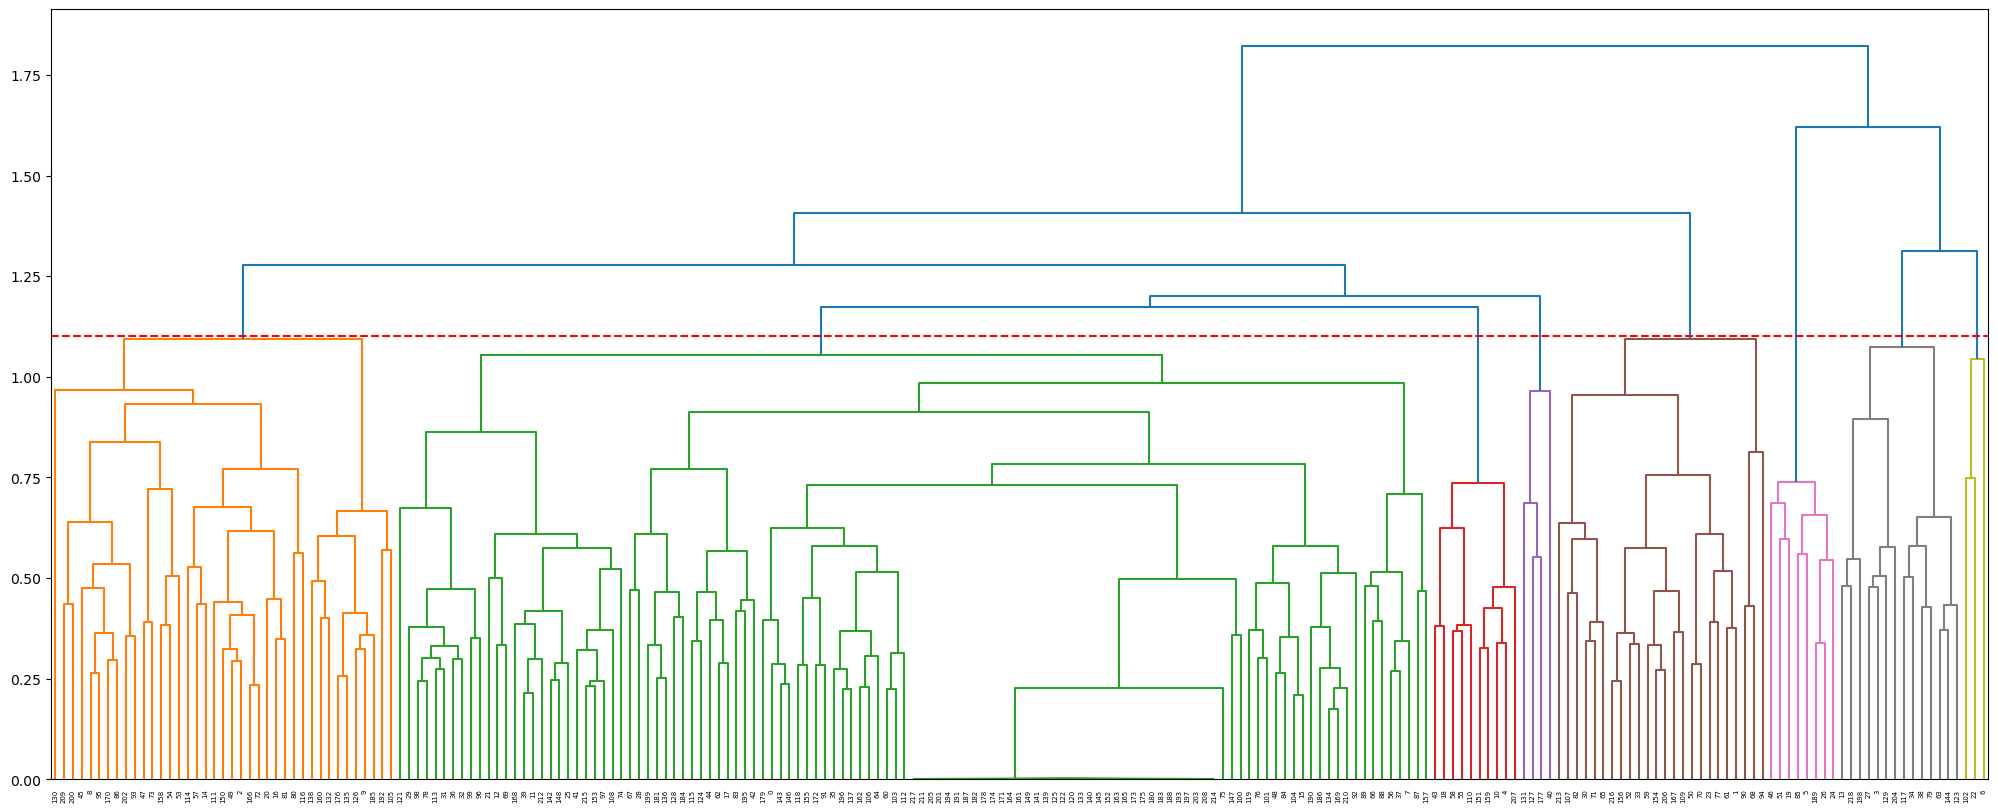

In [119]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_deep, color_threshold = thresh)
plt.axhline(y=thresh, c='r', linestyle='--')

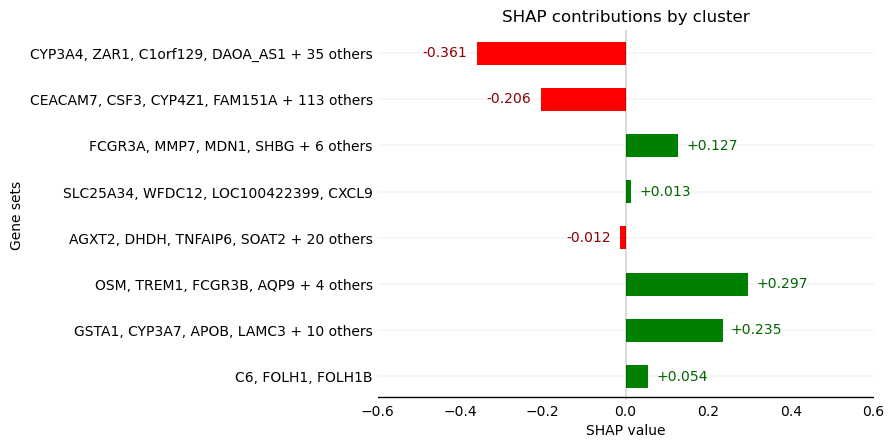

In [120]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
plt.axhline(7.45,linewidth=1., color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe;
clusters correspond to above dendrogram from left to right;
can choose threshold to get more / fewer clusters

In [121]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")

### Example: CD no ulcer patients

In [122]:
# patient_cluster_cd_deep = linkage(df_cd_deep, 'ward', metric='euclidean', optimal_ordering=True)
gene_cluster_cd_plain = linkage(df_cd_plain.T, 'ward', metric='euclidean', optimal_ordering=True)

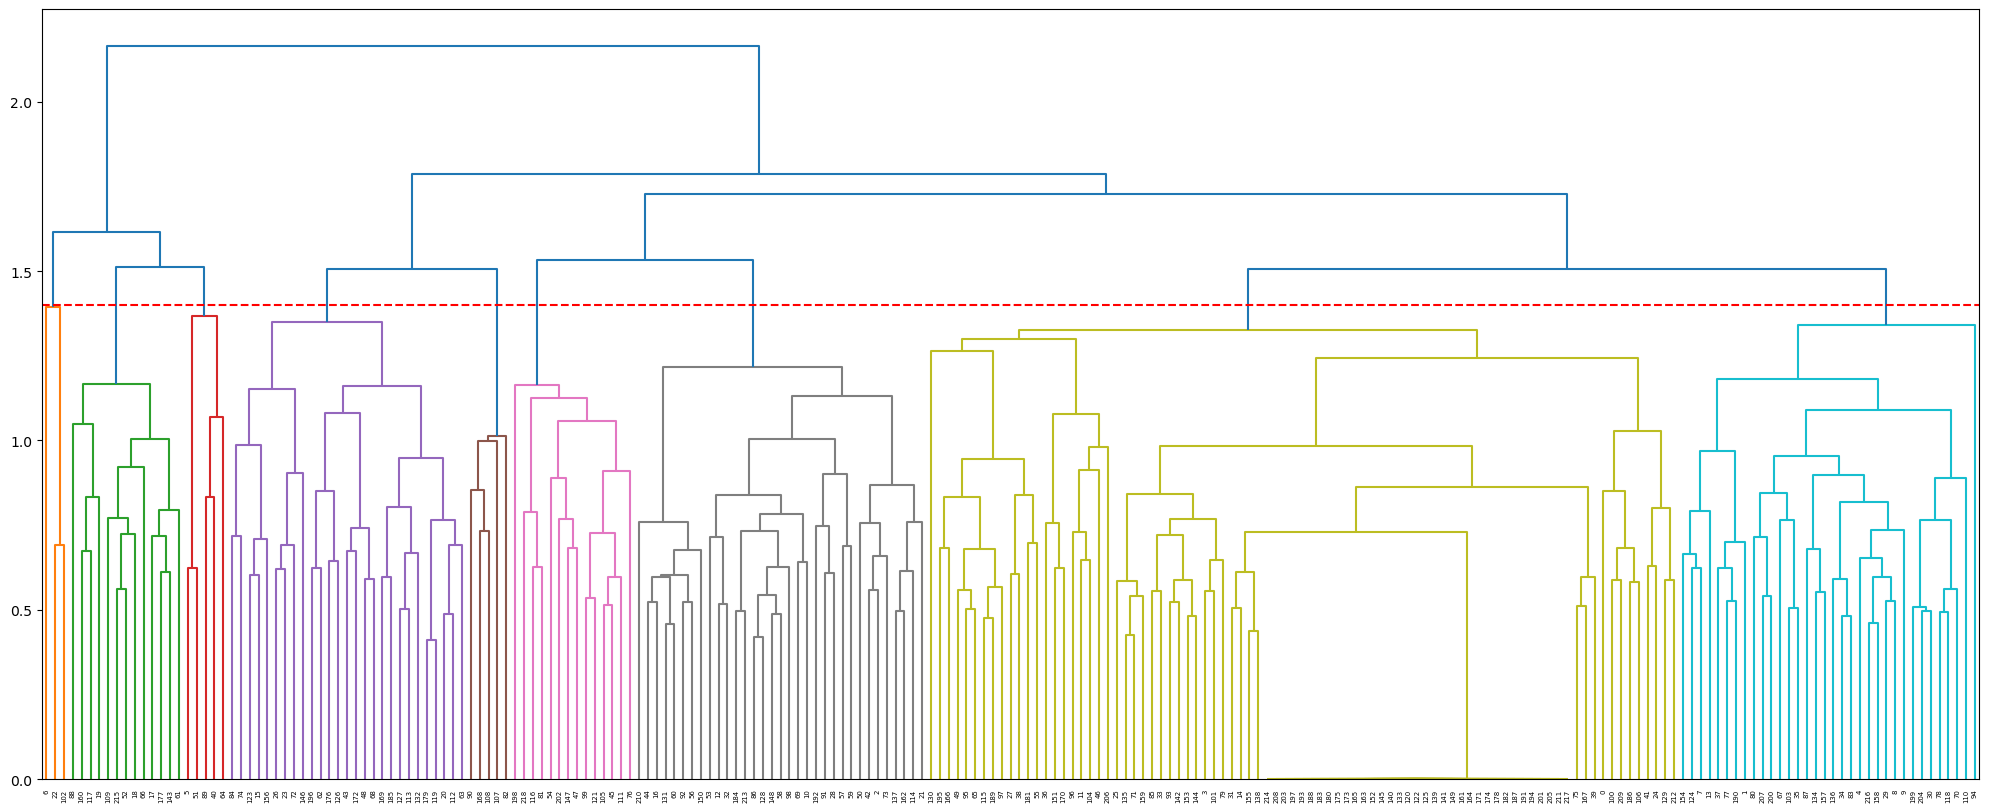

In [145]:
thresh = 1.4
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold = thresh)
# dn = dendrogram(fl)
plt.axhline(y=thresh, c='r', linestyle='--')

In [146]:
dn_ids = np.asarray(dn['ivl'], dtype='int')
dn_ids

array([  6,  22, 102,  88, 160, 117,  19, 109, 215,  52,  18,  66,  17,
       177, 143,  61,   5,  51,  89,  40,  64,  84,  74, 123,  15, 156,
        26,  23,  72, 146, 196,  62, 176, 126,  43, 172,  48,  68, 169,
       185, 127, 113, 132, 179, 119,  20, 112,  63,  90, 168, 108, 107,
        82, 198, 218, 116,  81,  54, 202, 147,  47,  99, 121, 105,  45,
       111,  76, 210,  44,  16, 131,  60,  92,  56, 150,  53,  12,  32,
       184, 213,  86, 128, 148,  58,  98,  69,  10, 192,  91,  28,  57,
        59,  50,  42,   2,  73, 137, 162, 114,  21, 130, 195, 166,  49,
        95,  65, 115, 189,  97,  27,  38, 181,  55,  36, 151, 170,  96,
        11, 104,  46, 206,  25, 135,  71, 159,  85,  33,  93, 142, 153,
       144,   3, 101,  79,  31,  14, 155, 138, 214, 208, 203, 197, 193,
       188, 183, 180, 175, 173, 165, 163, 152, 145, 140, 133, 120, 122,
       125, 139, 141, 149, 161, 164, 171, 174, 178, 182, 187, 191, 194,
       201, 205, 211, 217,  75, 167,  39,   0, 100, 209, 186, 10

In [147]:
df_cd_plain.columns

Index(['AADAC', 'APOA1', 'APOA4', 'APOB', 'APOC3', 'AQP9', 'C6', 'CEACAM7',
       'CHI3L1', 'ABCC2',
       ...
       'TAF15', 'ZFYVE20', 'LOC100420253', 'LY6G5B', 'C5orf58', 'RSL24D1P1',
       'MIEN1', 'PCBP1_AS1', 'LOC100133165', 'DNAJB8'],
      dtype='object', length=219)

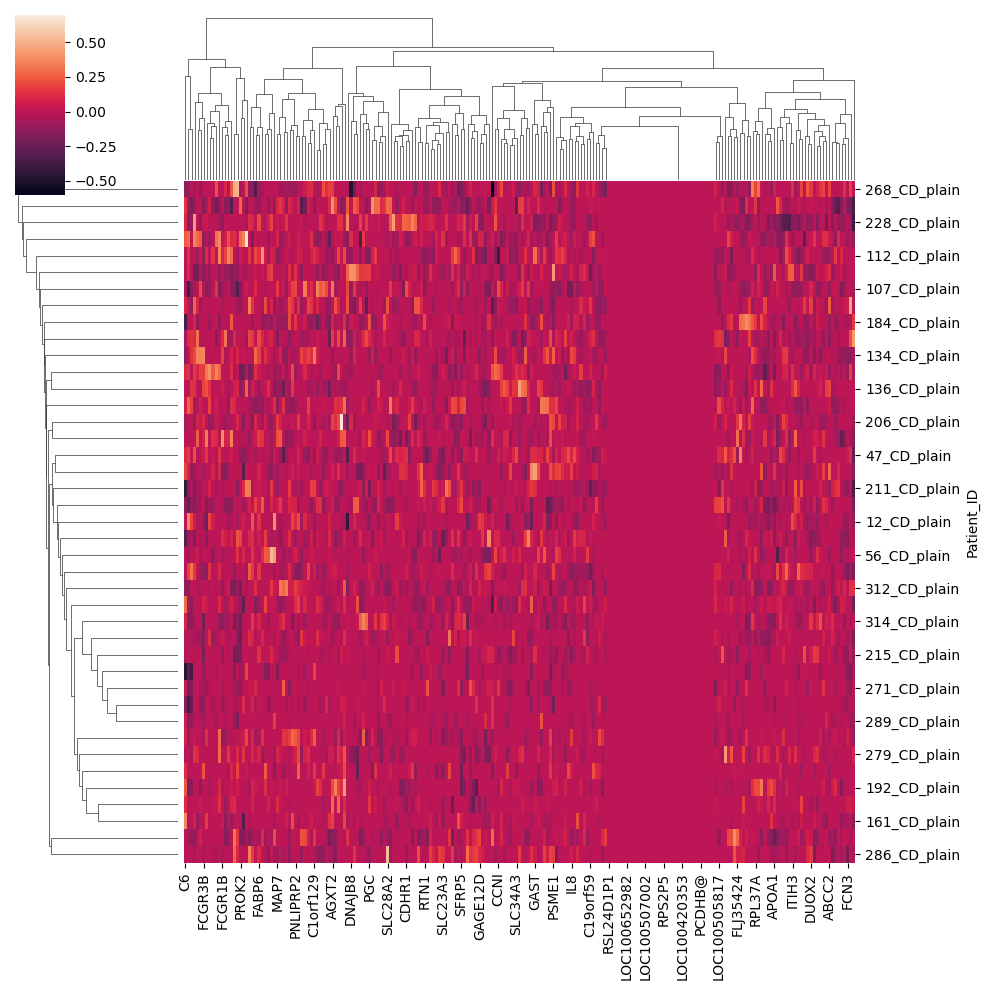

In [148]:
# shap values across genes (CD deep ulcer) - shows contribution of genes to disease symptom prediction for patients with given symptoms

# g = sns.clustermap(df_cd_deep, col_linkage=gc, row_linkage=patient_cluster_cd_deep)
g = sns.clustermap(df_cd_plain, col_linkage=gene_cluster_cd_plain)

## Aggregate bar plot, showing possible gene modules alongside SHAP contributions

In [149]:
gene_cluster_cd_plain

array([[1.20000000e+02, 1.22000000e+02, 0.00000000e+00, 2.00000000e+00],
       [2.19000000e+02, 1.25000000e+02, 0.00000000e+00, 3.00000000e+00],
       [1.33000000e+02, 2.20000000e+02, 0.00000000e+00, 4.00000000e+00],
       [2.21000000e+02, 1.39000000e+02, 0.00000000e+00, 5.00000000e+00],
       [1.40000000e+02, 2.22000000e+02, 0.00000000e+00, 6.00000000e+00],
       [2.23000000e+02, 1.41000000e+02, 0.00000000e+00, 7.00000000e+00],
       [1.45000000e+02, 2.24000000e+02, 0.00000000e+00, 8.00000000e+00],
       [2.25000000e+02, 1.49000000e+02, 0.00000000e+00, 9.00000000e+00],
       [1.52000000e+02, 2.26000000e+02, 0.00000000e+00, 1.00000000e+01],
       [2.27000000e+02, 1.61000000e+02, 0.00000000e+00, 1.10000000e+01],
       [1.63000000e+02, 2.28000000e+02, 0.00000000e+00, 1.20000000e+01],
       [2.29000000e+02, 1.64000000e+02, 0.00000000e+00, 1.30000000e+01],
       [1.65000000e+02, 2.30000000e+02, 0.00000000e+00, 1.40000000e+01],
       [2.31000000e+02, 1.71000000e+02, 0.00000000e

In [150]:
cluster_labels = fcluster(gene_cluster_cd_plain, thresh, criterion='distance')
# cluster_labels = fcluster(gene_cluster_cd_plain, 8, criterion='maxclust')
cluster_labels.shape

(219,)

In [151]:
leaders(gene_cluster_cd_plain, cluster_labels)

(array([418, 427, 428, 426, 405, 417, 420, 424, 425], dtype=int32),
 array([2, 3, 1, 4, 5, 6, 7, 8, 9], dtype=int32))

In [152]:
leader_ids = leaders(gene_cluster_cd_plain, cluster_labels)[1]
leader_ids

array([2, 3, 1, 4, 5, 6, 7, 8, 9], dtype=int32)

In [153]:
cluster_labels

array([8, 9, 7, 8, 9, 3, 1, 9, 9, 9, 7, 8, 7, 9, 8, 4, 7, 2, 2, 2, 4, 7,
       1, 4, 8, 8, 4, 8, 7, 9, 9, 8, 7, 8, 9, 9, 8, 9, 8, 8, 3, 8, 7, 4,
       7, 6, 8, 6, 4, 8, 7, 3, 2, 7, 6, 8, 7, 7, 7, 7, 7, 2, 4, 4, 3, 8,
       2, 9, 4, 7, 9, 8, 4, 7, 4, 8, 6, 9, 9, 8, 9, 6, 5, 9, 4, 8, 7, 9,
       2, 3, 5, 7, 7, 8, 9, 8, 8, 8, 7, 6, 8, 8, 1, 9, 8, 6, 8, 5, 5, 2,
       9, 6, 4, 4, 7, 8, 6, 2, 9, 4, 8, 6, 8, 4, 9, 8, 4, 4, 7, 8, 8, 7,
       4, 8, 9, 8, 9, 7, 8, 8, 8, 8, 8, 2, 8, 8, 4, 6, 7, 8, 7, 8, 8, 8,
       9, 8, 4, 9, 9, 8, 2, 8, 7, 8, 8, 8, 8, 8, 5, 4, 8, 8, 4, 8, 8, 8,
       4, 2, 8, 4, 8, 8, 8, 8, 7, 4, 8, 8, 8, 8, 9, 8, 7, 8, 8, 8, 4, 8,
       6, 9, 9, 8, 6, 8, 9, 8, 8, 9, 8, 8, 7, 8, 8, 7, 8, 2, 9, 8, 6],
      dtype=int32)

In [154]:
gene_df = df_cd_plain.describe().T
gene_df['gene_symbol']  = df_cd_plain.columns
gene_df["group_num"] = cluster_labels

gene_df

,count,mean,std,min,25%,50%,75%,max,gene_symbol,group_num
AADAC,41.0,0.023235,0.098784,-0.201131,0.000000,0.0,0.000000,0.426976,AADAC,8
APOA1,41.0,-0.028315,0.101090,-0.245486,-0.082309,0.0,0.000000,0.244024,APOA1,9
APOA4,41.0,-0.009191,0.069835,-0.254295,0.000000,0.0,0.000000,0.159703,APOA4,7
APOB,41.0,-0.021765,0.062534,-0.146103,-0.068252,0.0,0.000000,0.165609,APOB,8
APOC3,41.0,-0.010519,0.081824,-0.197109,-0.050203,0.0,0.000000,0.167641,APOC3,9
...,...,...,...,...,...,...,...,...,...,...
RSL24D1P1,41.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,RSL24D1P1,8
MIEN1,41.0,0.014710,0.092004,-0.111435,0.000000,0.0,0.000000,0.393486,MIEN1,2
PCBP1_AS1,41.0,-0.000449,0.065200,-0.140847,0.000000,0.0,0.024073,0.145206,PCBP1_AS1,9
LOC100133165,41.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,LOC100133165,8


In [155]:
# mean_df = gene_df[['mean','group_num']]
mean_df = gene_df[['mean','group_num','gene_symbol']]
mean_df

,mean,group_num,gene_symbol
AADAC,0.023235,8,AADAC
APOA1,-0.028315,9,APOA1
APOA4,-0.009191,7,APOA4
APOB,-0.021765,8,APOB
APOC3,-0.010519,9,APOC3
...,...,...,...
RSL24D1P1,0.000000,8,RSL24D1P1
MIEN1,0.014710,2,MIEN1
PCBP1_AS1,-0.000449,9,PCBP1_AS1
LOC100133165,0.000000,8,LOC100133165


In [156]:

mean_df["gene_symbol"] = mean_df.index
mean_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,mean,group_num,gene_symbol
AADAC,0.023235,8,AADAC
APOA1,-0.028315,9,APOA1
APOA4,-0.009191,7,APOA4
APOB,-0.021765,8,APOB
APOC3,-0.010519,9,APOC3
...,...,...,...
RSL24D1P1,0.000000,8,RSL24D1P1
MIEN1,0.014710,2,MIEN1
PCBP1_AS1,-0.000449,9,PCBP1_AS1
LOC100133165,0.000000,8,LOC100133165


In [157]:
agg_df = mean_df.groupby(['group_num'])
agg_df = agg_df.apply(group_fn)
agg_df

,sum,gene_count,grouped_genes
group_num,,,
1,-0.063560,3,"[C6, FOLH1, FOLH1B]"
2,0.081773,13,"[XPNPEP2, CYP4F11, RASL11A, SLC11A1, MIEN1, FC..."
3,-0.023221,5,"[TM4SF4, AQP9, S100A12, CXCL9, PROK2]"
4,0.201083,27,"[FABP6, NAT8B, SOAT2, ALDH1A2, NAT8, SNORD89, ..."
5,0.146197,5,"[DHDH, AGXT2, FAM151A, SERPINA9, PDIA5]"
6,-0.044838,14,"[MUC5B, SLC28A2, LILRA3, PTK2B, CLEC5A, PGC, S..."
7,-0.416693,33,"[GSTA2, IL1RN, CNTFR, ZFYVE20, SLC10A2, UGT1A6..."
8,-0.150621,85,"[AADAC, GAST, CRIP1, CEP78, GSTA1, LOC10050573..."
9,-0.413249,34,"[LRRC43, GUCA2B, RPL37A, ABCC2, ITIH3, CUBN, H..."


In [158]:

# agg_df = mean_df.groupby(['group_num']).agg(sum=('mean','sum'), 
#       gene_count=('mean','count'), grouped_genes=('gene_symbol', 'mean', test))
# result = result.rename(columns={'categorize' : 'Buy/Sell'})
agg_df["cluster_labels"] = agg_df["grouped_genes"].apply(group_labels)
# agg_df["cluster_labels"] = agg_df["count"].apply(add_other)

agg_df['cluster_labels'] = agg_df.apply(lambda x: add_other(x["gene_count"], x["cluster_labels"]), axis=1)
agg_df

,sum,gene_count,grouped_genes,cluster_labels
group_num,,,,
1,-0.063560,3,"[C6, FOLH1, FOLH1B]","C6, FOLH1, FOLH1B"
2,0.081773,13,"[XPNPEP2, CYP4F11, RASL11A, SLC11A1, MIEN1, FC...","XPNPEP2, CYP4F11, RASL11A, SLC11A1 + 9 others"
3,-0.023221,5,"[TM4SF4, AQP9, S100A12, CXCL9, PROK2]","TM4SF4, AQP9, S100A12, CXCL9 + 1 others"
4,0.201083,27,"[FABP6, NAT8B, SOAT2, ALDH1A2, NAT8, SNORD89, ...","FABP6, NAT8B, SOAT2, ALDH1A2 + 23 others"
5,0.146197,5,"[DHDH, AGXT2, FAM151A, SERPINA9, PDIA5]","DHDH, AGXT2, FAM151A, SERPINA9 + 1 others"
6,-0.044838,14,"[MUC5B, SLC28A2, LILRA3, PTK2B, CLEC5A, PGC, S...","MUC5B, SLC28A2, LILRA3, PTK2B + 10 others"
7,-0.416693,33,"[GSTA2, IL1RN, CNTFR, ZFYVE20, SLC10A2, UGT1A6...","GSTA2, IL1RN, CNTFR, ZFYVE20 + 29 others"
8,-0.150621,85,"[AADAC, GAST, CRIP1, CEP78, GSTA1, LOC10050573...","AADAC, GAST, CRIP1, CEP78 + 81 others"
9,-0.413249,34,"[LRRC43, GUCA2B, RPL37A, ABCC2, ITIH3, CUBN, H...","LRRC43, GUCA2B, RPL37A, ABCC2 + 30 others"


In [159]:
sorted_idxs = get_idx_order(dn_ids, df_cd_plain, agg_df)

In [160]:
# agg_df.index = leader_ids
agg_df.index = sorted_idxs
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.063560,3,"[C6, FOLH1, FOLH1B]","C6, FOLH1, FOLH1B"
2,0.081773,13,"[XPNPEP2, CYP4F11, RASL11A, SLC11A1, MIEN1, FC...","XPNPEP2, CYP4F11, RASL11A, SLC11A1 + 9 others"
3,-0.023221,5,"[TM4SF4, AQP9, S100A12, CXCL9, PROK2]","TM4SF4, AQP9, S100A12, CXCL9 + 1 others"
4,0.201083,27,"[FABP6, NAT8B, SOAT2, ALDH1A2, NAT8, SNORD89, ...","FABP6, NAT8B, SOAT2, ALDH1A2 + 23 others"
5,0.146197,5,"[DHDH, AGXT2, FAM151A, SERPINA9, PDIA5]","DHDH, AGXT2, FAM151A, SERPINA9 + 1 others"
6,-0.044838,14,"[MUC5B, SLC28A2, LILRA3, PTK2B, CLEC5A, PGC, S...","MUC5B, SLC28A2, LILRA3, PTK2B + 10 others"
7,-0.416693,33,"[GSTA2, IL1RN, CNTFR, ZFYVE20, SLC10A2, UGT1A6...","GSTA2, IL1RN, CNTFR, ZFYVE20 + 29 others"
8,-0.150621,85,"[AADAC, GAST, CRIP1, CEP78, GSTA1, LOC10050573...","AADAC, GAST, CRIP1, CEP78 + 81 others"
9,-0.413249,34,"[LRRC43, GUCA2B, RPL37A, ABCC2, ITIH3, CUBN, H...","LRRC43, GUCA2B, RPL37A, ABCC2 + 30 others"


In [161]:
agg_df = agg_df.sort_index()
agg_df

,sum,gene_count,grouped_genes,cluster_labels
1,-0.063560,3,"[C6, FOLH1, FOLH1B]","C6, FOLH1, FOLH1B"
2,0.081773,13,"[XPNPEP2, CYP4F11, RASL11A, SLC11A1, MIEN1, FC...","XPNPEP2, CYP4F11, RASL11A, SLC11A1 + 9 others"
3,-0.023221,5,"[TM4SF4, AQP9, S100A12, CXCL9, PROK2]","TM4SF4, AQP9, S100A12, CXCL9 + 1 others"
4,0.201083,27,"[FABP6, NAT8B, SOAT2, ALDH1A2, NAT8, SNORD89, ...","FABP6, NAT8B, SOAT2, ALDH1A2 + 23 others"
5,0.146197,5,"[DHDH, AGXT2, FAM151A, SERPINA9, PDIA5]","DHDH, AGXT2, FAM151A, SERPINA9 + 1 others"
6,-0.044838,14,"[MUC5B, SLC28A2, LILRA3, PTK2B, CLEC5A, PGC, S...","MUC5B, SLC28A2, LILRA3, PTK2B + 10 others"
7,-0.416693,33,"[GSTA2, IL1RN, CNTFR, ZFYVE20, SLC10A2, UGT1A6...","GSTA2, IL1RN, CNTFR, ZFYVE20 + 29 others"
8,-0.150621,85,"[AADAC, GAST, CRIP1, CEP78, GSTA1, LOC10050573...","AADAC, GAST, CRIP1, CEP78 + 81 others"
9,-0.413249,34,"[LRRC43, GUCA2B, RPL37A, ABCC2, ITIH3, CUBN, H...","LRRC43, GUCA2B, RPL37A, ABCC2 + 30 others"


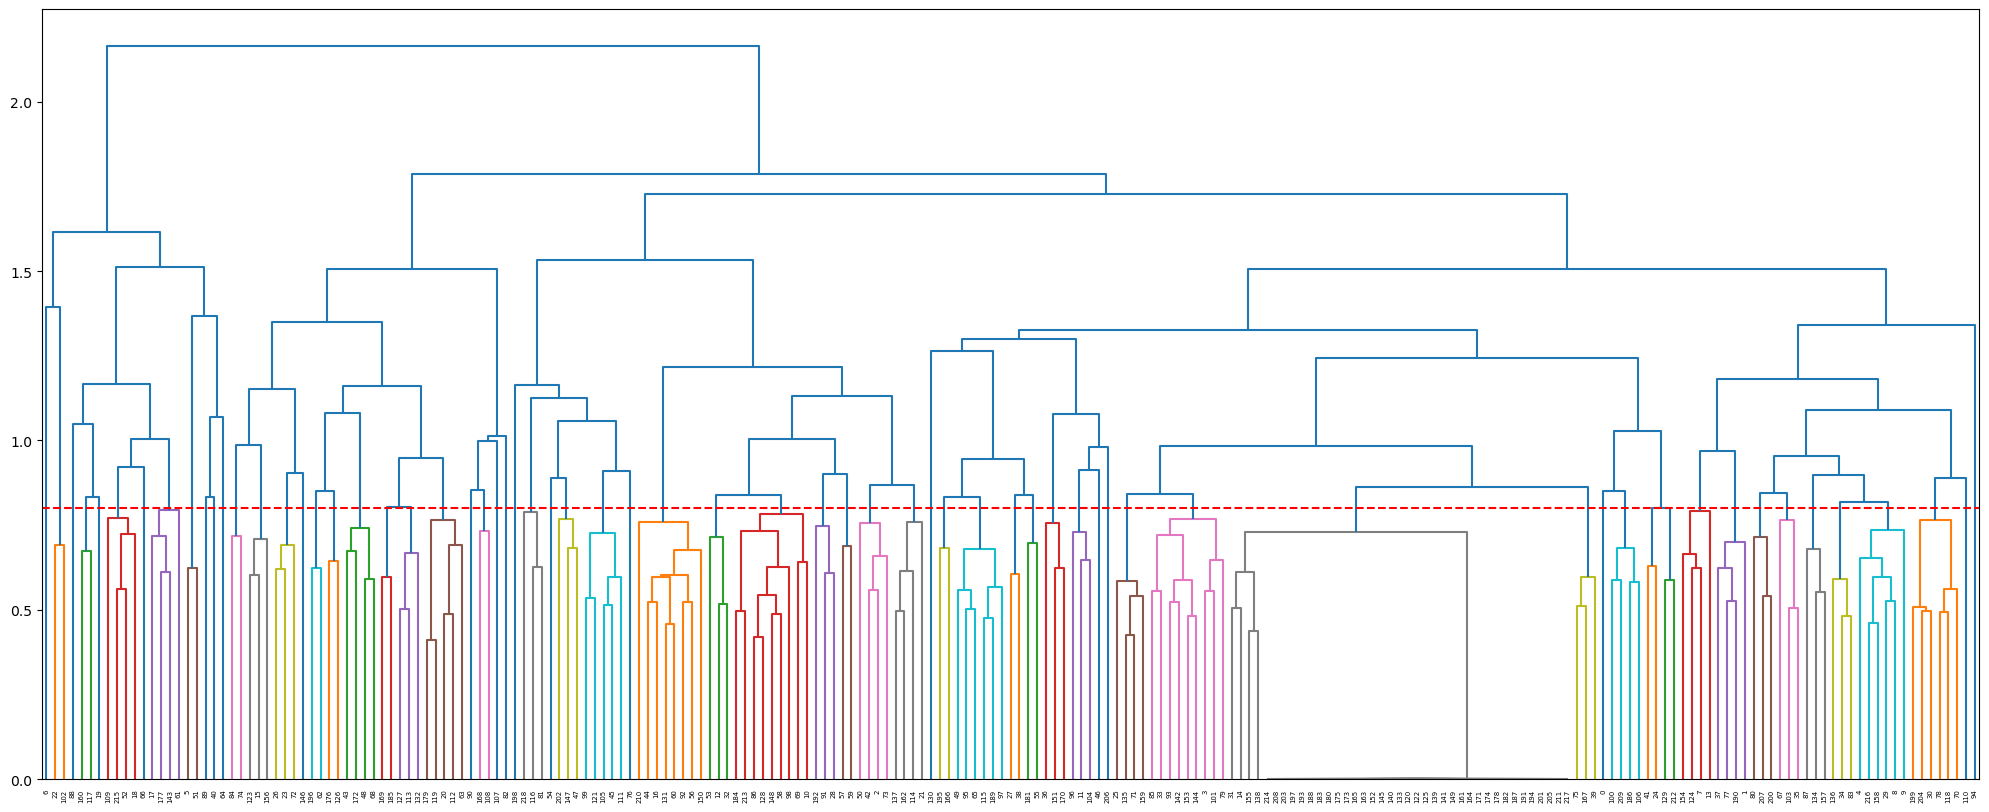

In [162]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(gene_cluster_cd_plain, color_threshold=.8, get_leaves=True)
plt.axhline(y=.8, c='r', linestyle='--')

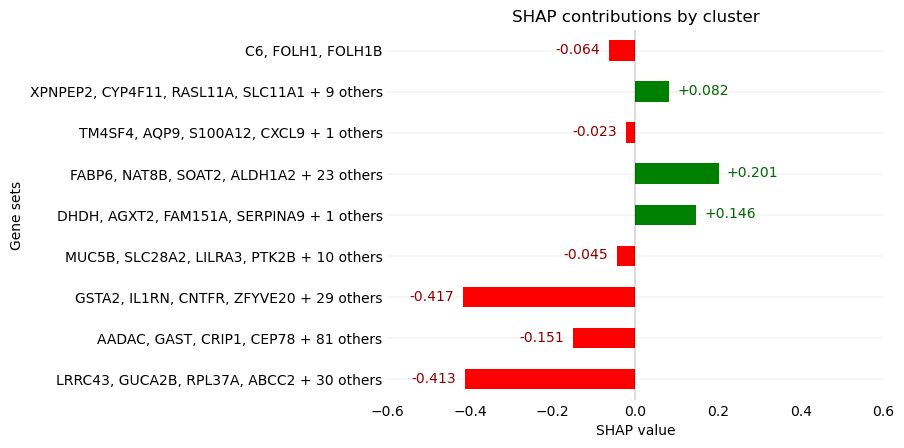

In [163]:
agg_df.plot.barh(x="cluster_labels", y="sum", legend=None, zorder=2, color=(agg_df['sum'] > 0).map({True: 'g',False: 'r'}))

plt.title('SHAP contributions by cluster')
plt.ylabel('Gene sets')
plt.xlabel('SHAP value')
plt.xlim((-.6,.6))
for i, v in enumerate(agg_df["sum"]):
    v = np.round(v, 3)
    vt = "+{:.3f}".format(v) if v >= 0 else "{:.3f}".format(v)
    offset = -.13 if v < 0 else .02
    colour = 'darkred' if v < 0 else 'darkgreen'
    plt.text(v + offset, i + .08, vt, color=colour, zorder=3)
    plt.axhline(i,linewidth=.07, color='k', zorder=1, linestyle='--')
    
    
plt.axvline(0,linewidth=.2, color='k')
size = fig.get_size_inches()[1]
plt.axhline(size + .045*size,linewidth=.9, color='k')

plt.tick_params(axis=u'both', which=u'both',length=0)
plt.gca().invert_yaxis()
plt.box(on=False)

plt.show()

gene names shown in sorted order;
can get full lists from dataframe
clusters correspond to above dendrogram from left to right
can choose threshold to get more / fewer clusters

In [164]:
# export to text file

for li in agg_df["grouped_genes"]:
    print(len(li),"genes:")
    for item in li:
        print(item)
    print("----------------------")